## Dataset Preprocessing Notebook

Opens the fits files using data_loader and filter the dataset using the catalog standardizer, then Saves the cleaned datasets in gzip files

### Import Statements and Load config.yaml file

In [1]:
import sys
sys.path.append("./util_classes")

import pandas             as pd
import numpy              as np
import matplotlib.pyplot  as plt
from astropy.io           import fits

from catalog_standardizer import CatalogStandardizer
from config_loader        import ConfigLoader
from data_loader          import DataLoader

In [2]:
config = ConfigLoader("/Users/admin/Documents/GitHub/Matched-Catalog-Analysis/src/configs/config.yaml")
data = DataLoader(0)

df_eROSITA = data.get_dataframe(config.EROSITA_PATH)
df_h20 = data.get_dataframe(config.H20_PATH)
df_cdfs = data.get_dataframe(config.CDFS_PATH)

### Initialize RA and DEC of Catalogs

In [3]:
df_eROSITA_RA, df_eROSITA_DEC = df_eROSITA['RA_RAW'], df_eROSITA['DEC_RAW']
df_h20_RA, df_h20_DEC = df_h20['ALPHA_J2000'], df_h20['DELTA_J2000']
df_cdfs_RA, df_cdfs_DEC = df_cdfs['RAJ2000'], df_cdfs['DEJ2000']

## RA and DEC Plots

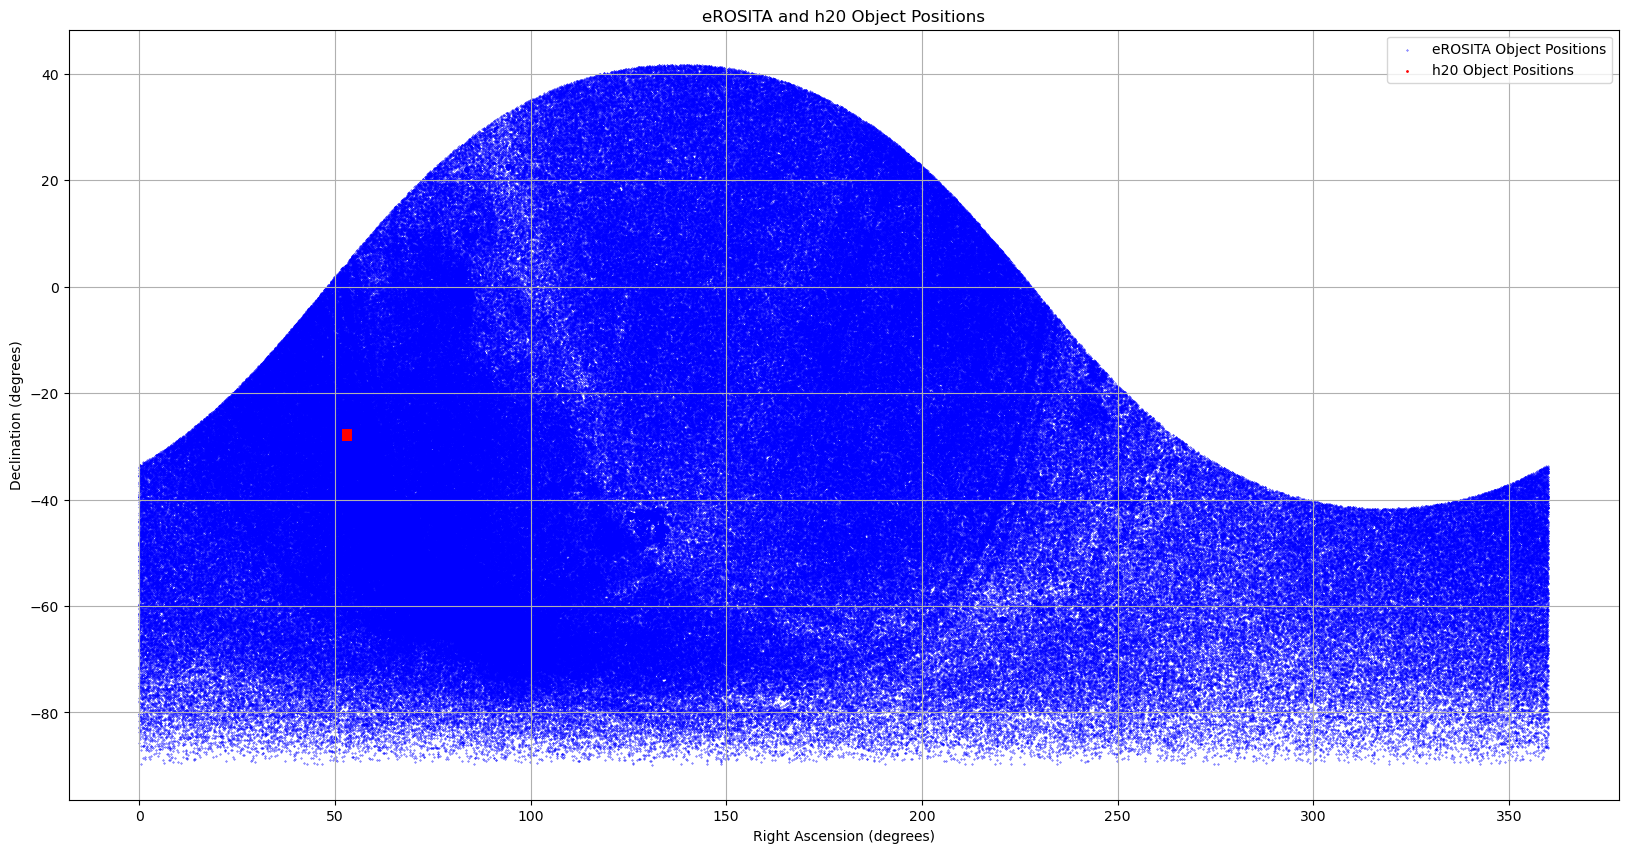

In [4]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.scatter(df_eROSITA_RA, df_eROSITA_DEC, c='blue', s=0.1, label='eROSITA Object Positions')
ax.scatter(df_h20_RA, df_h20_DEC, c='red', s=1, label='h20 Object Positions')

ax.set_title('eROSITA and h20 Object Positions')
ax.set_xlabel('Right Ascension (degrees)')
ax.set_ylabel('Declination (degrees)')
ax.grid(True)
ax.legend()

plt.show()

/opt/anaconda3/envs/catalog_matching/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


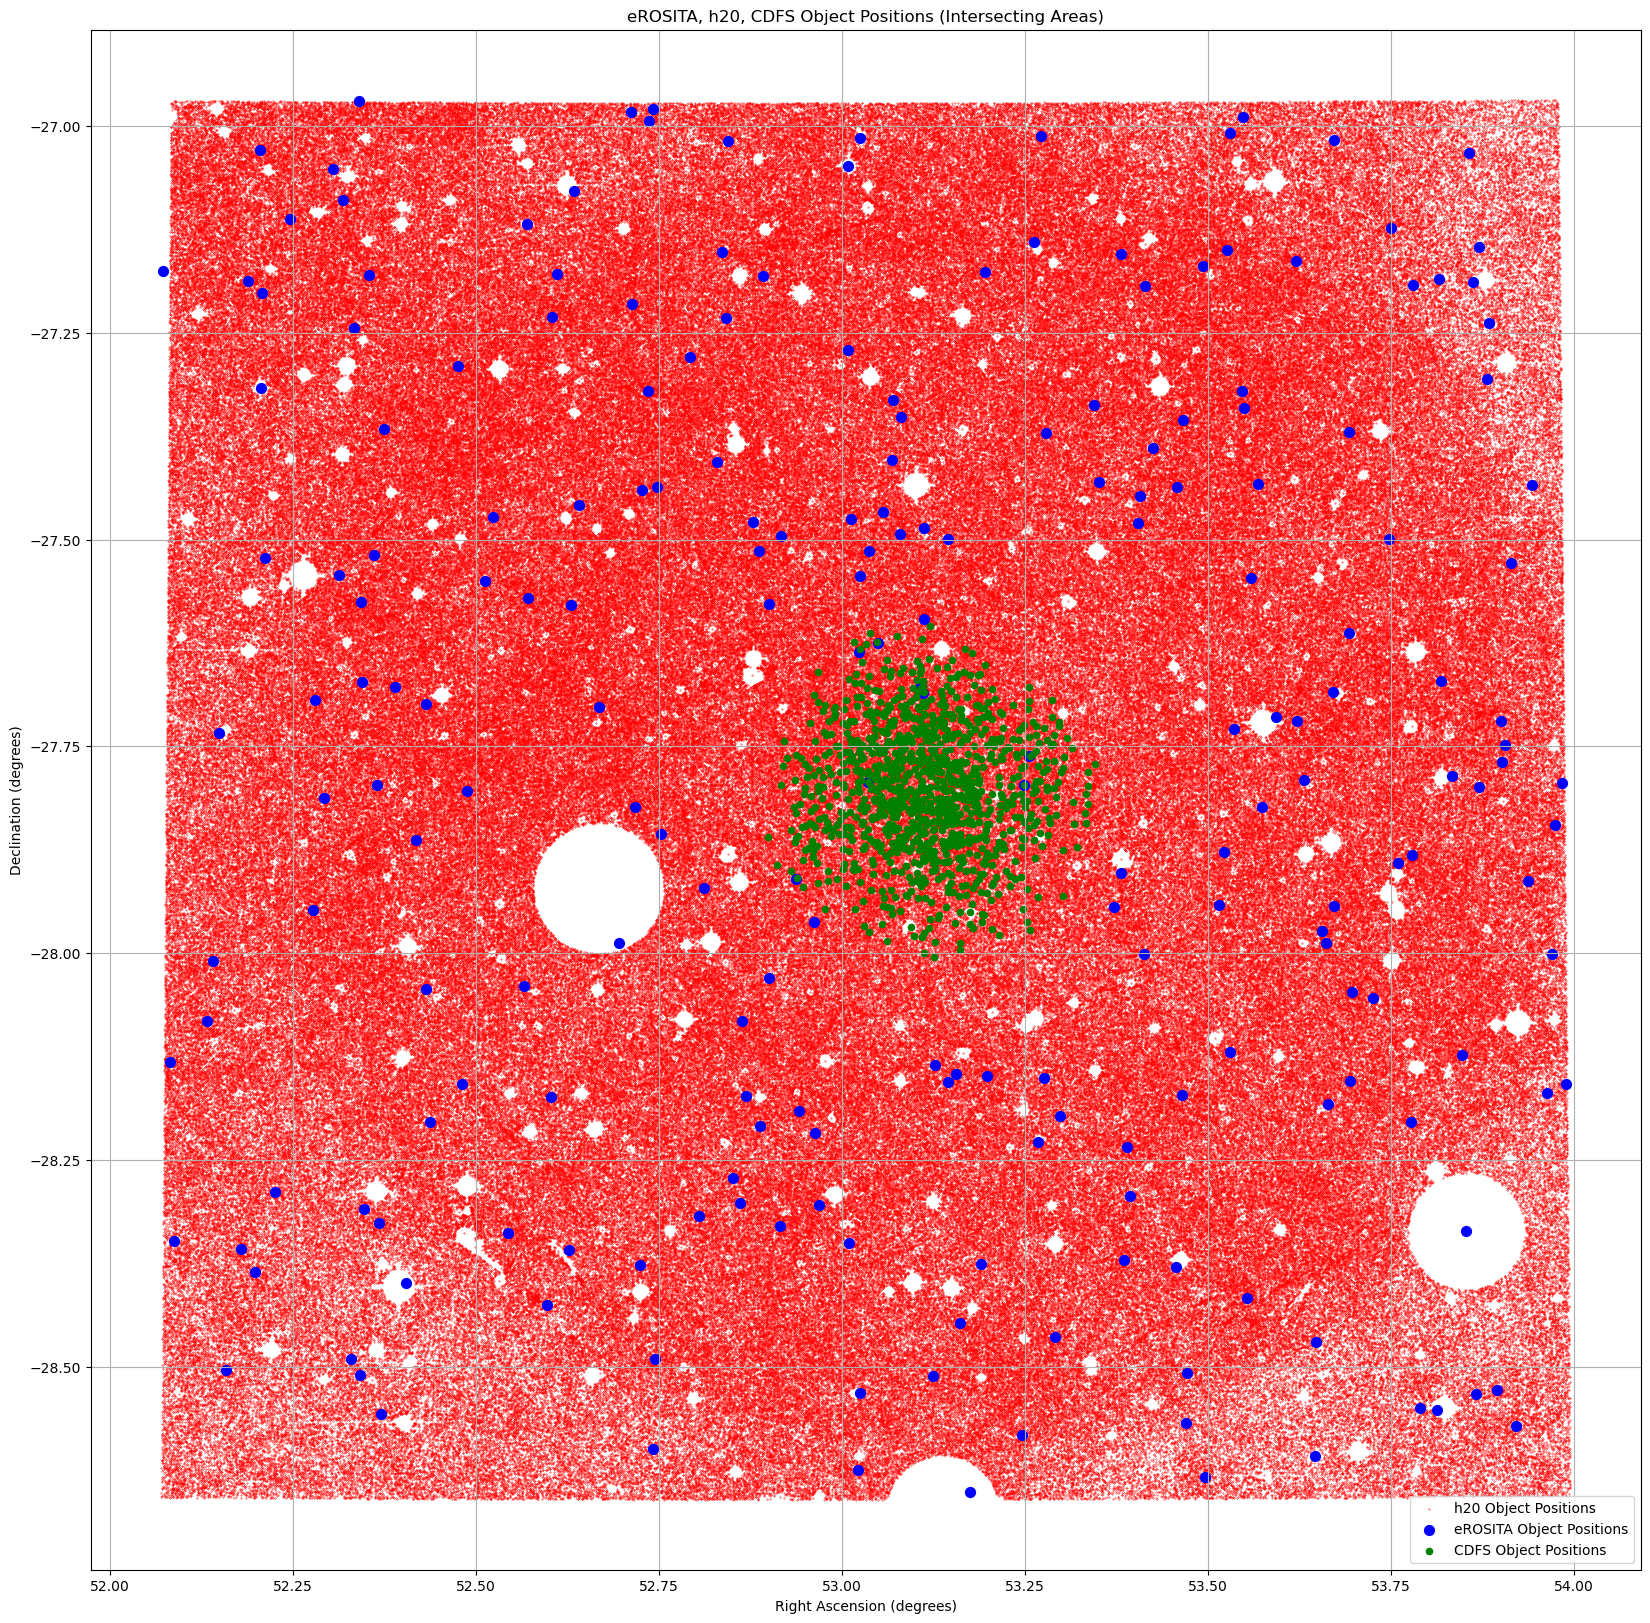

In [5]:
min_RA = max(df_eROSITA_RA.min(), df_h20_RA.min())
max_RA = min(df_eROSITA_RA.max(), df_h20_RA.max())
min_DEC = max(df_eROSITA_DEC.min(), df_h20_DEC.min())
max_DEC = min(df_eROSITA_DEC.max(), df_h20_DEC.max())


filtered_eROSITA = df_eROSITA[
    (df_eROSITA_RA >= min_RA) & (df_eROSITA_RA <= max_RA) &
    (df_eROSITA_DEC >= min_DEC) & (df_eROSITA_DEC <= max_DEC)
]

filtered_h20 = df_h20[
    (df_h20_RA >= min_RA) & (df_h20_RA <= max_RA) &
    (df_h20_DEC >= min_DEC) & (df_h20_DEC <= max_DEC)
]

filtered_eROSITA_RA, filtered_eROSITA_DEC = filtered_eROSITA['RA_RAW'], filtered_eROSITA['DEC_RAW']
filtered_h20_RA, filtered_h20_DEC = filtered_h20['ALPHA_J2000'], filtered_h20['DELTA_J2000']

fig, ax = plt.subplots(figsize=(20, 20))

ax.scatter(filtered_h20_RA, filtered_h20_DEC, c='red', s=0.1, label='h20 Object Positions')
ax.scatter(filtered_eROSITA_RA, filtered_eROSITA_DEC, c='blue', s=50, label='eROSITA Object Positions')
ax.scatter(df_cdfs_RA, df_cdfs_DEC, c='green', s=20, label='CDFS Object Positions')


ax.set_title('eROSITA, h20, CDFS Object Positions (Intersecting Areas)')
ax.set_xlabel('Right Ascension (degrees)')
ax.set_ylabel('Declination (degrees)')
ax.grid(True)
ax.legend()

plt.show()

## Catalog Standardization

Filter the eROSITA dataset so that only the objects in the H20 regions are included

In [6]:
df_h20['ERR_TOTAL'] = np.sqrt(df_h20['ERRY_MODEL']**2 + df_h20['ERRX_MODEL']**2)

eROSITA_standardizer = CatalogStandardizer(
    df_eROSITA['IAUNAME'],
    df_eROSITA['RA'],
    df_eROSITA['DEC'],
    df_eROSITA["POS_ERR"],
    df_eROSITA["ML_FLUX_1"]
)

h20_standardizer = CatalogStandardizer(
    df_h20['ID'],
    df_h20['ALPHA_J2000'],
    df_h20['DELTA_J2000'],
    df_h20['ERR_TOTAL'],
    df_h20['CFHT_u_FLUX']
)

h20_standardized = h20_standardizer.standardize()
eROSITA_standardized = eROSITA_standardizer.standardize()

min_RA = max(h20_standardized['ra'].min(), eROSITA_standardized['ra'].min())
max_RA = min(h20_standardized['ra'].max(), eROSITA_standardized['ra'].max())
min_DEC = max(h20_standardized['dec'].min(), eROSITA_standardized['dec'].min())
max_DEC = min(h20_standardized['dec'].max(), eROSITA_standardized['dec'].max())

h20_standardized = h20_standardized[
    (h20_standardized['ra'] >= min_RA) & (h20_standardized['ra'] <= max_RA) &
    (h20_standardized['dec'] >= min_DEC) & (h20_standardized['dec'] <= max_DEC)
].reset_index(drop=True)

eROSITA_standardized = eROSITA_standardized[
    (eROSITA_standardized['ra'] >= min_RA) & (eROSITA_standardized['ra'] <= max_RA) &
    (eROSITA_standardized['dec'] >= min_DEC) & (eROSITA_standardized['dec'] <= max_DEC)
].reset_index(drop=True)

Filter CDFS data and generate LYR txt file so that only the objects in the H20 regions are included. eROSITA and H20 txt files have already been generated.

In [7]:
df_cdfs_lyr = pd.concat([
    df_cdfs['Seq'],
    df_cdfs['RAJ2000'],
    df_cdfs['DEJ2000'],
    df_cdfs['errPos'],    
    df_cdfs['errPos'],  
], axis=1)

df_cdfs_lyr.columns = [
    'ID',
    'RA',
    'DEC',
    'RA_err',
    'Dec_err',
]


df_cdfs_lyr.to_csv(f"{config.INPUT_CATALOG_PATH}/cdfs_LYR.txt", sep=",", index=False)